## Setup

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from tensorflow.keras import layers

keras = tf.keras

In [0]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
 
  
  
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset
  
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
# Loading Data
import pandas as pd
#!ls /content/drive/'My Drive'/'Colab Notebooks'
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Term_project_simulation/selected_data_ISONE.csv')
data.head()

date  year  month  day  weekday  hour   demand  temperature
0  2003/3/1  2003      3    1        7     1  12863.0           23
1  2003/3/1  2003      3    1        7     2  12389.0           22
2  2003/3/1  2003      3    1        7     3  12155.0           21
3  2003/3/1  2003      3    1        7     4  12072.0           21
4  2003/3/1  2003      3    1        7     5  12160.0           22

In [7]:
data['load'] = data['demand']/data['demand'].values.max()
data.head()

date  year  month  day  weekday  hour   demand  temperature      load
0  2003/3/1  2003      3    1        7     1  12863.0           23  0.465680
1  2003/3/1  2003      3    1        7     2  12389.0           22  0.448519
2  2003/3/1  2003      3    1        7     3  12155.0           21  0.440048
3  2003/3/1  2003      3    1        7     4  12072.0           21  0.437043
4  2003/3/1  2003      3    1        7     5  12160.0           22  0.440229

In [8]:
data = data.set_index("date")
data.head()

year  month  day  weekday  hour   demand  temperature      load
date                                                                     
2003/3/1  2003      3    1        7     1  12863.0           23  0.465680
2003/3/1  2003      3    1        7     2  12389.0           22  0.448519
2003/3/1  2003      3    1        7     3  12155.0           21  0.440048
2003/3/1  2003      3    1        7     4  12072.0           21  0.437043
2003/3/1  2003      3    1        7     5  12160.0           22  0.440229

In [9]:
series = data.loc[:'2006/12/31']
series.head()

year  month  day  weekday  hour   demand  temperature      load
date                                                                     
2003/3/1  2003      3    1        7     1  12863.0           23  0.465680
2003/3/1  2003      3    1        7     2  12389.0           22  0.448519
2003/3/1  2003      3    1        7     3  12155.0           21  0.440048
2003/3/1  2003      3    1        7     4  12072.0           21  0.437043
2003/3/1  2003      3    1        7     5  12160.0           22  0.440229

In [10]:
series.tail()

year  month  day  weekday  hour   demand  temperature      load
date                                                                       
2006/12/31  2006     12   31        1    20  16400.0           30  0.593730
2006/12/31  2006     12   31        1    21  15742.0           31  0.569908
2006/12/31  2006     12   31        1    22  15020.0           30  0.543769
2006/12/31  2006     12   31        1    23  14233.0           29  0.515278
2006/12/31  2006     12   31        1    24  13442.0           29  0.486641

In [11]:
train_series = series.loc[:'2005/12/31']
train_series.tail()

year  month  day  weekday  hour   demand  temperature      load
date                                                                       
2005/12/31  2005     12   31        7    20  17052.0           26  0.617334
2005/12/31  2005     12   31        7    21  16334.0           29  0.591340
2005/12/31  2005     12   31        7    22  15564.0           29  0.563464
2005/12/31  2005     12   31        7    23  14804.0           29  0.535950
2005/12/31  2005     12   31        7    24  14000.0           29  0.506842

In [12]:
valid_series = series.loc['2006/1/1':]
valid_series.tail(2)

year  month  day  weekday  hour   demand  temperature      load
date                                                                       
2006/12/31  2006     12   31        1    23  14233.0           29  0.515278
2006/12/31  2006     12   31        1    24  13442.0           29  0.486641

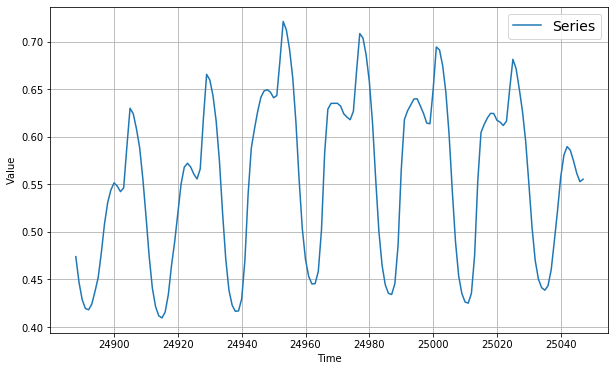

In [13]:
# Entire Series
split_time = len(train_series)
Series = series['load'].values
time = np.arange(len(series))

x_train = Series[:split_time]
x_valid = Series[split_time:]

time_valid = time[split_time:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid,start =0, end=160, label="Series")

## Simple RNN Forecasting

In [14]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 24
train_set = window_dataset(x_train, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 4.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mape"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
195/195 [==============================] - 13s 67ms/step - loss: 0.2250 - mape: 117.6915
Epoch 2/100
195/195 [==============================] - 10s 51ms/step - loss: 0.0785 - mape: 60.8339
Epoch 3/100
195/195 [==============================] - 10s 53ms/step - loss: 0.0363 - mape: 37.9289
Epoch 4/100
195/195 [==============================] - 10s 53ms/step - loss: 0.0260 - mape: 32.7188
Epoch 5/100
195/195 [==============================] - 11s 54ms/step - loss: 0.0238 - mape: 32.1130
Epoch 6/100
195/195 [==============================] - 10s 53ms/step - loss: 0.0233 - mape: 32.1172
Epoch 7/100
195/195 [==============================] - 11s 54ms/step - loss: 0.0229 - mape: 32.0278
Epoch 8/100
195/195 [==============================] - 10s 54ms/step - loss: 0.0226 - mape: 31.8244
Epoch 9/100
195/195 [==============================] - 10s 53ms/step - loss: 0.0222 - mape: 31.5558
Epoch 10/100
195/195 [==============================] - 10s 53ms/step - loss: 0.0217 - mape: 31.233

[1e-07, 0.1, 0, 0.19]

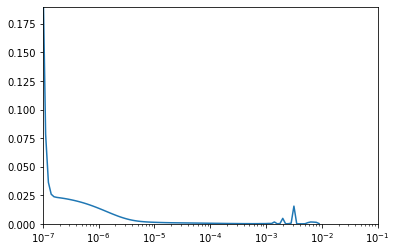

In [21]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-1, 0, 0.19])

In [0]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 24
train_set = window_dataset(x_train, window_size, batch_size=128)
valid_set = window_dataset(x_valid, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 4)
])
optimizer = keras.optimizers.SGD(lr=1e-3, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mape"])
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
model.fit(train_set, epochs=1200,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

In [23]:
model = keras.models.load_model("my_checkpoint.h5")

export_path_keras = "/{}.h5".format("content/drive/My Drive/Colab Notebooks/Term_project_simulation/rnn_1")
print(export_path_keras)
model.save(export_path_keras)

/content/drive/My Drive/Colab Notebooks/Term_project_simulation/rnn_1.h5


In [0]:
rnn_forecast = model_forecast(
    model,
    Series[split_time - window_size:-1],
    window_size)[:, 0]

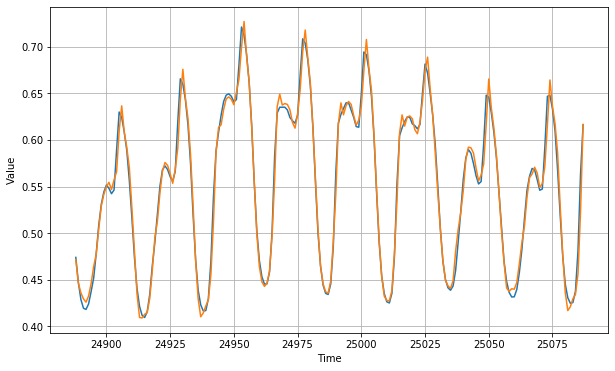

In [26]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid,start =0, end = 200)
plot_series(time_valid, rnn_forecast, start = 0, end = 200)

In [27]:
keras.metrics.mean_absolute_percentage_error(x_valid, rnn_forecast).numpy()

1.2465761

## Sequence-to-Sequence Forecasting

In [0]:
def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
for X_batch, Y_batch in seq2seq_window_dataset(tf.range(10), 3,
                                               batch_size=1):
    print("X:", X_batch.numpy())
    print("Y:", Y_batch.numpy())

In [31]:
import time
start = time.time()
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 24
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 4)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mape"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

end = time.time()

print("Time elasped in minutes", (end-start)/60)

Epoch 1/100
195/195 [==============================] - 12s 62ms/step - loss: 0.7018 - mape: 212.8958
Epoch 2/100
195/195 [==============================] - 11s 54ms/step - loss: 0.5533 - mape: 174.7279
Epoch 3/100
195/195 [==============================] - 10s 54ms/step - loss: 0.4601 - mape: 147.2480
Epoch 4/100
195/195 [==============================] - 11s 54ms/step - loss: 0.4052 - mape: 130.6904
Epoch 5/100
195/195 [==============================] - 10s 54ms/step - loss: 0.3723 - mape: 122.3949
Epoch 6/100
195/195 [==============================] - 11s 54ms/step - loss: 0.3506 - mape: 118.4406
Epoch 7/100
195/195 [==============================] - 10s 54ms/step - loss: 0.3341 - mape: 116.1660
Epoch 8/100
195/195 [==============================] - 10s 53ms/step - loss: 0.3195 - mape: 114.2195
Epoch 9/100
195/195 [==============================] - 10s 53ms/step - loss: 0.3055 - mape: 112.0537
Epoch 10/100
195/195 [==============================] - 10s 53ms/step - loss: 0.2914 - mape

[1e-07, 1.0, 0, 0.5]

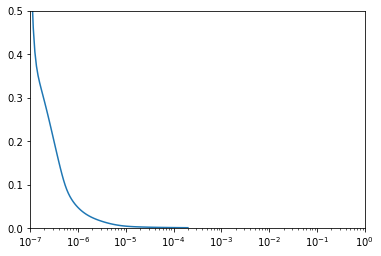

In [33]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-0, 0, 0.5])

In [35]:
start = time.time()
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 24
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 4)
])
optimizer = keras.optimizers.SGD(lr=1e-4, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mape"])
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint2.h5", save_best_only=True)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

end = time.time()

print("Time elasped in minutes ", (end - start)/60)

Epoch 1/500
195/195 [==============================] - 14s 74ms/step - loss: 0.1094 - mape: 54.3249 - val_loss: 0.0000e+00 - val_mape: 0.0000e+00
Epoch 2/500
195/195 [==============================] - 12s 61ms/step - loss: 0.0046 - mape: 14.4651 - val_loss: 0.0031 - val_mape: 12.3304
Epoch 3/500
195/195 [==============================] - 12s 61ms/step - loss: 0.0026 - mape: 11.0591 - val_loss: 0.0021 - val_mape: 10.1610
Epoch 4/500
195/195 [==============================] - 12s 62ms/step - loss: 0.0018 - mape: 9.4168 - val_loss: 0.0016 - val_mape: 8.8266
Epoch 5/500
195/195 [==============================] - 12s 62ms/step - loss: 0.0015 - mape: 8.3677 - val_loss: 0.0013 - val_mape: 8.0225
Epoch 6/500
195/195 [==============================] - 12s 61ms/step - loss: 0.0012 - mape: 7.6236 - val_loss: 0.0011 - val_mape: 7.3490
Epoch 7/500
195/195 [==============================] - 12s 61ms/step - loss: 0.0011 - mape: 7.0640 - val_loss: 0.0010 - val_mape: 6.8454
Epoch 8/500
195/195 [=======

In [36]:
model = keras.models.load_model("my_checkpoint2.h5")

export_path_keras = "/{}.h5".format("content/drive/My Drive/Colab Notebooks/Term_project_simulation/rnn_seq_1")
print(export_path_keras)
model.save(export_path_keras)

/content/drive/My Drive/Colab Notebooks/Term_project_simulation/rnn_seq_1.h5


In [0]:
rnn_forecast = model_forecast(model, Series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

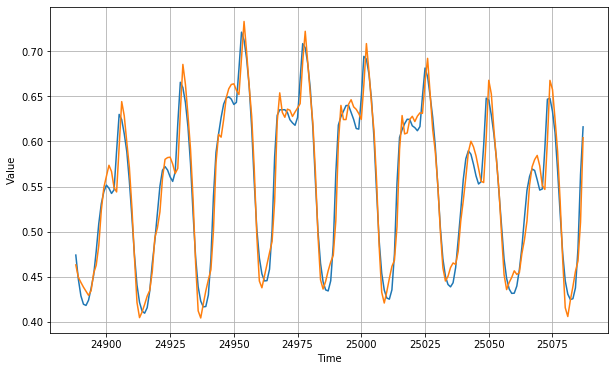

In [39]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start = 0, end = 200)
plot_series(time_valid, rnn_forecast, start = 0, end = 200)

In [40]:
keras.metrics.mean_absolute_percentage_error(x_valid, rnn_forecast).numpy()

2.5022604